<a href="https://colab.research.google.com/github/Sagargupta16/Stock-market-prediction/blob/main/SMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler

# Fetch historical data for a stock (e.g., Apple)
data = yf.download('AAPL', start='2020-01-01', end='2023-01-01')

# Select relevant features
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data['Average'] = (data['High'] + data['Low']) / 2

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Convert to PyTorch tensors
data_scaled = torch.FloatTensor(data_scaled)

# Reshape data for LSTM input
data_scaled = data_scaled.view(-1, 6)  # 6 features: Open, High, Low, Close, Volume, Average

# Create sequences for LSTM
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i:i + tw]
        train_label = input_data[i + tw:i + tw + 1, 3]  # Predicting the 'Close' value
        inout_seq.append((train_seq, train_label))
    return inout_seq

seq_length = 5  # Number of days for the sequence
inout_seq = create_inout_sequences(data_scaled, seq_length)


[*********************100%%**********************]  1 of 1 completed


In [ ]:
#Designing the Model
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size=6, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training the Model
epochs = 150

for epoch in range(epochs):
    for seq, labels in inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if epoch % 25 == 0:
        print(f'epoch: {epoch} loss: {single_loss.item()}')

print(f'Training complete. Final loss: {single_loss.item()}')


epoch: 0 loss: 0.0005252695991657674
epoch: 25 loss: 0.0014838576316833496
epoch: 50 loss: 0.0010161723475903273
epoch: 75 loss: 0.0008429119479842484
epoch: 100 loss: 0.0008297496242448688
epoch: 125 loss: 0.0007720395224168897
Training complete. Final loss: 0.000669739383738488


Mean Squared Error: 11.248650886318787


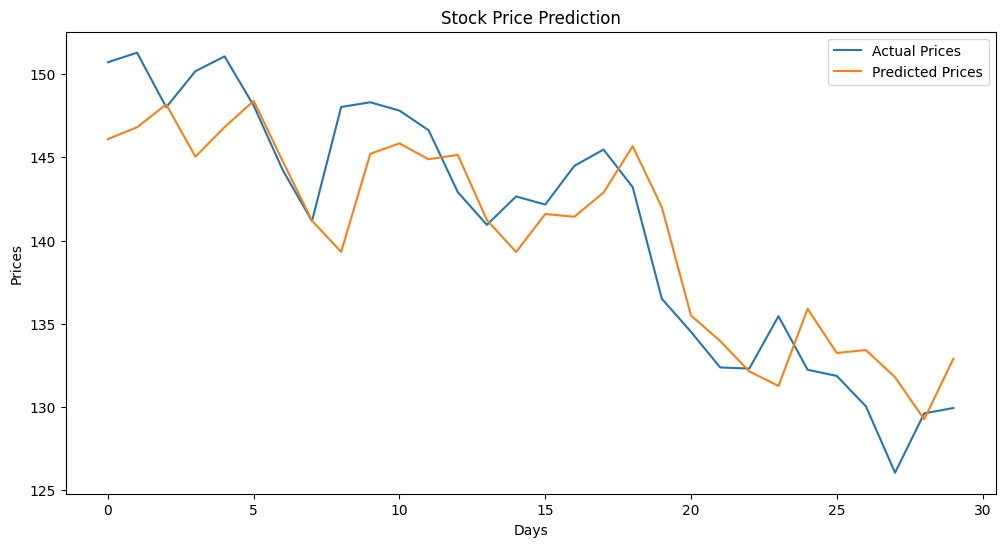

In [ ]:
# Evaluating the Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Define the sequence length (same as used during training)
seq_length = 5

# Prepare the test data (using the last N+seq_length days from your dataset)
N = 30  # Number of days to consider for testing
test_data = data_scaled[-(N+seq_length):]

# Function to create sequences (same as used during training)
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i:i + tw]
        train_label = input_data[i + tw:i + tw + 1, 3]  # Assuming column index 3 is 'Close'
        inout_seq.append((train_seq, train_label))
    return inout_seq

# Create sequences from test data
test_sequences = create_inout_sequences(test_data, seq_length)

# Extract sequences and labels
test_seq = torch.stack([ts[0] for ts in test_sequences])
test_labels = torch.stack([ts[1] for ts in test_sequences])

# Make predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_predictions = []
    for seq in test_seq:
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        test_predictions.append(model(seq).item())

# Inverse transform the entire test dataset to get actual prices
test_data_inversed = scaler.inverse_transform(test_data)

# Extract the actual 'Close' prices from the inversed test data
actual_prices = test_data_inversed[seq_length:, 3]  # Column index 3 for 'Close'

# Prepare a dummy array for inverse transforming the predicted prices
# Adjust the size of the dummy array to match the number of predictions
dummy_array = np.zeros((len(test_predictions), test_data_inversed.shape[1]))
dummy_array[:, 3] = np.array(test_predictions)  # Replace 'Close' column with predictions

# Inverse transform the dummy array
predicted_prices_inversed = scaler.inverse_transform(dummy_array)
predicted_prices = predicted_prices_inversed[:, 3]  # Extract the 'Close' prices

# Calculate the mean squared error
mse = mean_squared_error(actual_prices, predicted_prices)
print(f"Mean Squared Error: {mse}")

# Plot the results
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()
